## Importowanie bibliotek

In [1]:
from skimage import io, color, morphology, filters, data, exposure, segmentation, measure, util
from matplotlib import pyplot as plt
import numpy as np
from scipy.cluster.vq import kmeans, vq
import imutils
import cv2

## Funkcja do wyświetlania dwóch obrazów obok siebie

In [2]:
def plot(img, is_color=False):
    plt.figure(figsize=(8,8))
    if is_color:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap = plt.cm.gray)
        
def plot_subplots(img1, img2):
    plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.imshow(img1, cmap = plt.cm.gray)
    plt.subplot(1,2,2)
    plt.imshow(img2, cmap = plt.cm.gray)
    plt.show()

## Funkcja do wyświetlania ośmiu obrazów obok siebie

In [3]:
def plot(img, is_color=False):
    plt.figure(figsize=(20,20))
    if is_color:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap = plt.cm.gray)
        
def plot_subploty(img1, img2, img3, img4, img5, img6, img7, img8):
    plt.figure(figsize=(12,12))
    plt.subplot(4,4,1)
    plt.imshow(img1, cmap = plt.cm.gray)
    plt.subplot(4,4,2)
    plt.imshow(img2, cmap = plt.cm.gray)
    plt.subplot(4,4,3)
    plt.imshow(img3, cmap = plt.cm.gray)
    plt.subplot(4,4,4)
    plt.imshow(img4, cmap = plt.cm.gray)
    plt.subplot(4,4,5)
    plt.imshow(img5, cmap = plt.cm.gray)
    plt.subplot(4,4,6)
    plt.imshow(img6, cmap = plt.cm.gray)
    plt.subplot(4,4,7)
    plt.imshow(img7, cmap = plt.cm.gray)
    plt.subplot(4,4,8)
    plt.imshow(img8, cmap = plt.cm.gray)    
    plt.show()

## Większość filtrów i funkcji uzywanych do późniejszej klasyfikacji

In [4]:
# Wczytanie obrazu z pliku
img = io.imread('20230410_180216.jpg')

# Konwersja obrazu kolorowego na obraz w skali szarości
img_gray = color.rgb2gray(img)

# Inwersja obrazu - odwrócenie kolorów
img_negative = 1-img_gray

# Zastosowanie adaptacyjnej wyrównania histogramu na obrazie negatywnym
img_equalized = exposure.equalize_adapthist(img_negative)

# Skalowanie wartości pikseli do zakresu 0-255 oraz konwersja typu na 'uint8'
img_equalized = (img_equalized*255).astype('uint8')

# Filtracja uśredniająca (mean filter) o rozmiarze okna 40x40 pikseli
img_filtered = filters.rank.mean(img_negative, np.ones([40,40]))

# Obliczenie progu Otsu na obrazie przefiltrowanym
threshold = filters.threshold_otsu(img_filtered)

# Binaryzacja obrazu przefiltrowanego z wykorzystaniem progu Otsu
img_bin = img_filtered > threshold

# Usunięcie pikseli brzegowych z binaryzowanego obrazu
img_cleared_borders = segmentation.clear_border(img_bin)

# Zastosowanie operacji morfologicznej "otwarcia" z użyciem kwadratowego elementu strukturalnego o boku 40 pikseli
img_opened = morphology.binary_opening(img_cleared_borders, np.ones([40,40]))


/var/folders/b5/vt5tbdrd3vsb9sjq0cdwyc900000gn/T/ipykernel_33627/3689167777.py:17: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  img_filtered = filters.rank.mean(img_negative, np.ones([40,40]))


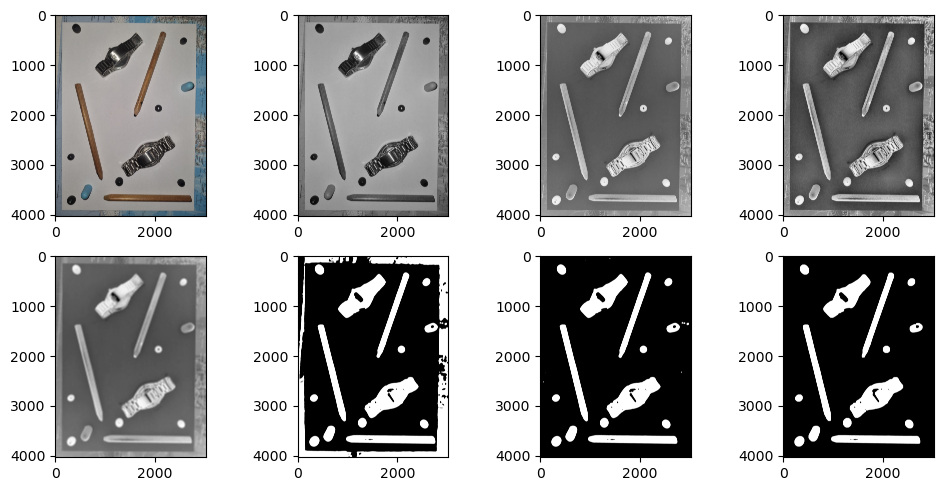

In [5]:
plot_subploty(img, img_gray, img_negative, img_equalized, img_filtered, img_bin, img_cleared_borders, img_opened)

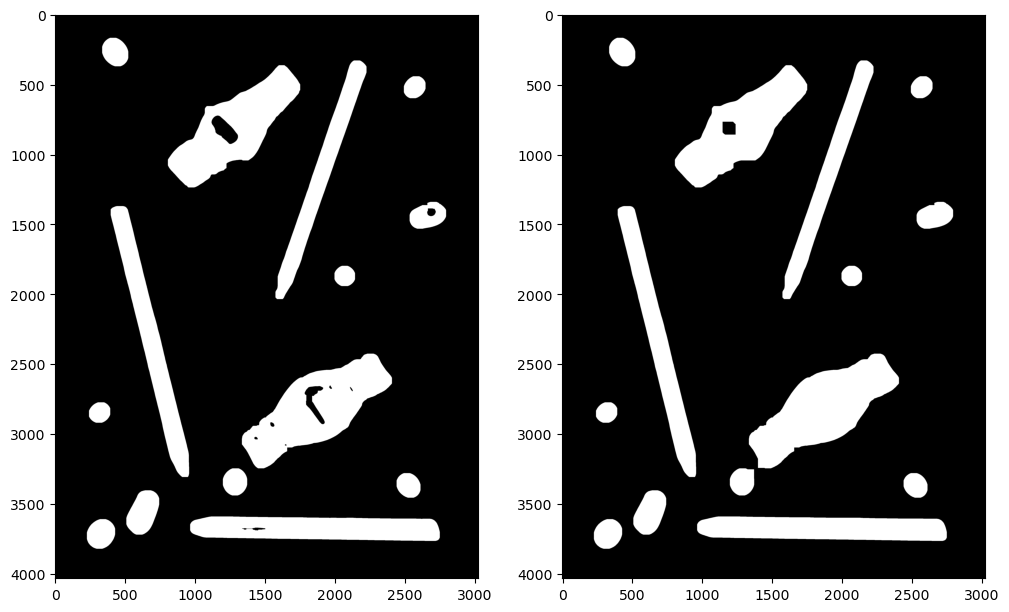

In [6]:
img_preprocessed = morphology.binary_closing(img_opened, np.ones([75,75]))
#zamknięcie ewentualnych szczelin między obiektami na obrazie.
plot_subplots(img_opened, img_preprocessed)

## Fukcje obliczające cechy charakterystyczne obiektów

In [7]:
def calculate_rectangularity(area, bounding_box_area):
    rectangularity = area / bounding_box_area
    return rectangularity
#Funkcja obliczająca wskaźnik prostokątności - stosunek pola figury do pola najmniejszego prostokąta otaczającego tę figurę.

def calculate_roundness(area, perimeter):
    roundness = (4 * np.pi * area) / (perimeter ** 2)
    return roundness
#Funkcja obliczająca wskaźnik zaokrąglenia - określa, jak bardzo figura przypomina okrąg; 
#im większa wartość, tym bardziej figura jest zaokrąglona.

def calculate_elongation(bounding_box_width, bounding_box_length):
    elongation = 1 - bounding_box_width / bounding_box_length
    return elongation
#Funkcja obliczająca wskaźnik wydłużenia - określa, jak bardzo figura jest wydłużona wzdłuż jednej z osi; 
#im mniejsza wartość, tym bardziej figura jest wydłużona.

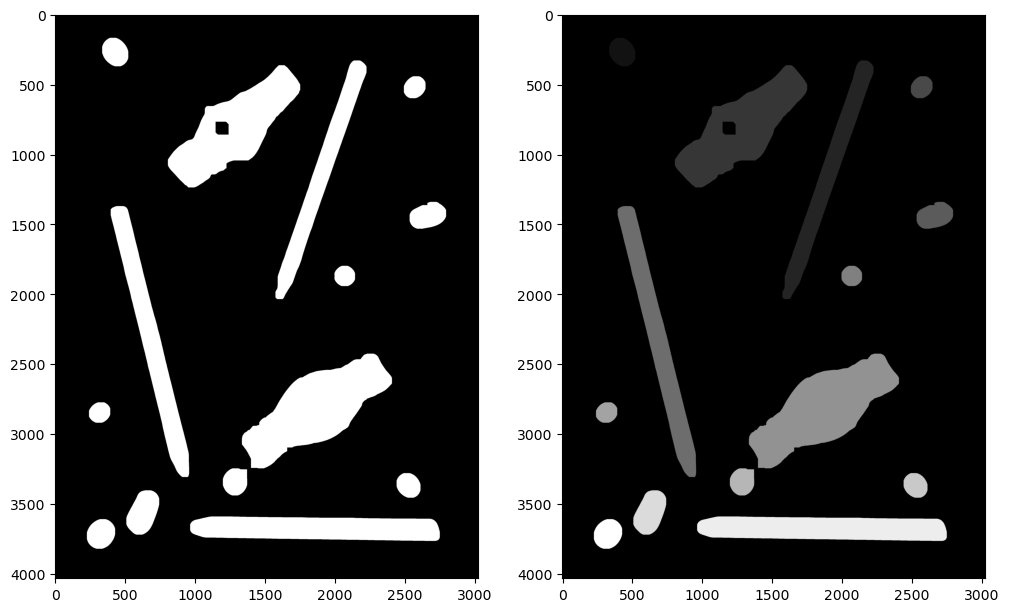

In [8]:
img_labeled = measure.label(img_preprocessed, connectivity=2)
plot_subplots(img_preprocessed, img_labeled)

In [9]:
regionprops = measure.regionprops(img_labeled)

In [10]:
labels = np.unique(img_labeled)[1:]
print(labels)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [11]:
# Tworzymy pustą listę do przechowywania wektorów cech
feature_vectors = []

# Iterujemy po etykietach i odpowiadającym im właściwościom regionów
for label, rp in zip(labels, regionprops):
    
    # Pobieramy obiekt o określonej etykiecie
    obj = img_labeled == label
    
    # Obliczamy cechy obiektu
    roundness = calculate_roundness(rp.area, rp.perimeter)  # obliczamy okrągłość na podstawie pola i obwodu
    rectangularity = calculate_rectangularity(rp.area, rp.bbox_area)  # obliczamy prostokątność na podstawie pola i obszaru ograniczającego prostokąta
    elongation = calculate_elongation(rp.bbox[3] - rp.bbox[2], rp.bbox[1] - rp.bbox[0])  # obliczamy wydłużenie na podstawie wymiarów ograniczającego prostokąta
    red_color = img[:,:,0][obj].mean()  # obliczamy średnią wartość czerwonego koloru dla pikseli obiektu
    green_color = img[:,:,1][obj].mean()  # obliczamy średnią wartość zielonego koloru dla pikseli obiektu
    blue_color = img[:,:,2][obj].mean()  # obliczamy średnią wartość niebieskiego koloru dla pikseli obiektu
    
    # Tworzymy wektor cech, który składa się z obliczonych cech
    feature_vector = [roundness, rectangularity, elongation, red_color, green_color, blue_color]

    # Dodajemy wektor cech do listy wektorów cech
    feature_vectors.append(feature_vector)


In [12]:
feature_vectors = np.array(feature_vectors)

In [13]:
# initial_k = np.stack([feature_vectors[10], feature_vectors[12], feature_vectors[14]])
initial_k = 4
centroids, _ = kmeans(feature_vectors, k_or_guess=initial_k, iter=20000, thresh=0.01)
print(centroids)

[[ 9.11811071e-01  8.08844927e-01  1.09094648e-02  5.33152421e+01
   5.17712636e+01  5.25523300e+01]
 [ 4.71903181e-01  4.39192709e-01  3.42098378e-02  6.93908266e+01
   6.59646099e+01  6.40090966e+01]
 [ 1.87995069e-01  4.29222661e-01  1.66294866e-02  1.07299870e+02
   7.88982914e+01  5.76025963e+01]
 [ 8.02827356e-01  7.36029208e-01 -4.31053019e-02  7.58850943e+01
   1.04367358e+02  1.17084270e+02]]


In [14]:
classes, _ = vq(feature_vectors, centroids)
print(classes)

[0 2 1 0 3 2 0 1 0 0 0 3 2 0]


In [15]:
masks = {}
for c in np.unique(classes):
    mask = np.zeros(img_labeled.shape)
    for label in labels[classes == c]:
        mask += img_labeled == label
    masks = {**masks, c: mask.astype(bool)}

In [16]:
def mark_objects(img, mask, colors):
    img_copy = img.copy()
    img_copy[mask, 0] = colors[0]
    img_copy[mask, 1] = colors[1]
    img_copy[mask, 2] = colors[2]
    plt.figure(figsize=(16,24))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(mask, cmap=plt.cm.gray)
    plt.subplot(1,3,3)
    plt.imshow(img_copy)
    plt.show()

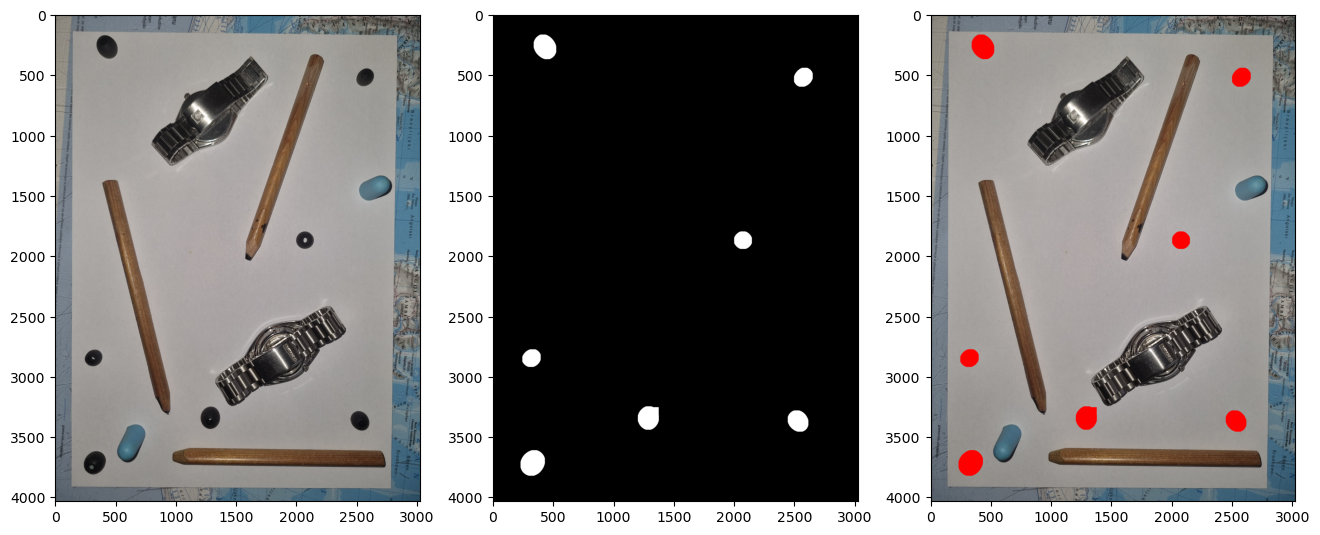

In [17]:
mark_objects(img, masks[0], (255,0,0))

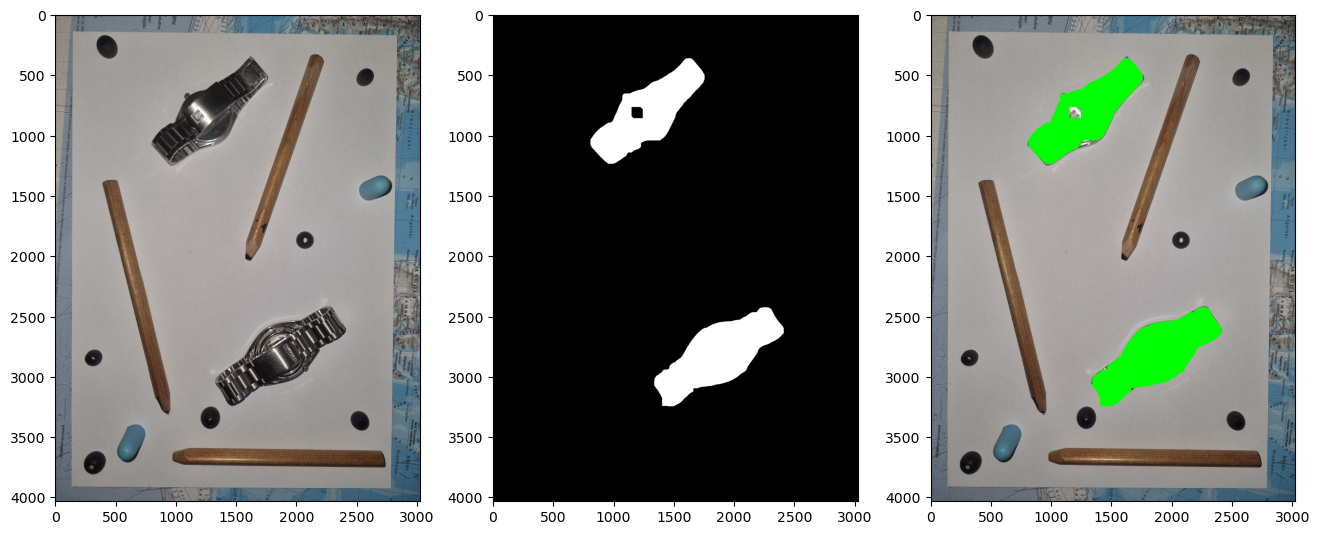

In [18]:
mark_objects(img, masks[1], (0,255,0))

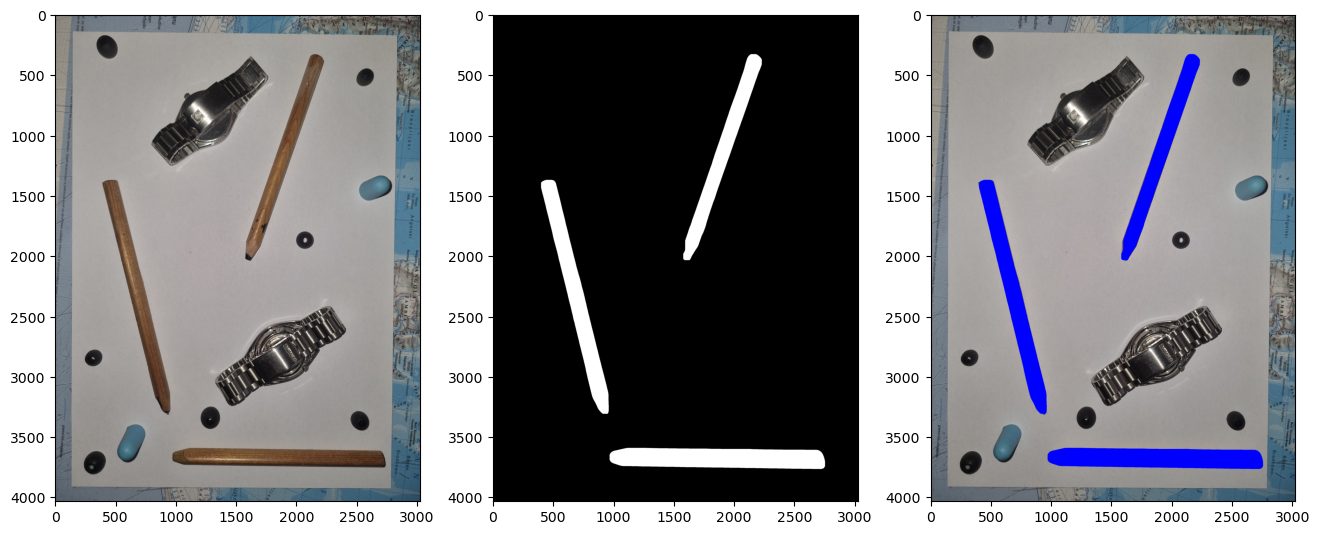

In [19]:
mark_objects(img, masks[2], (0,0,255))

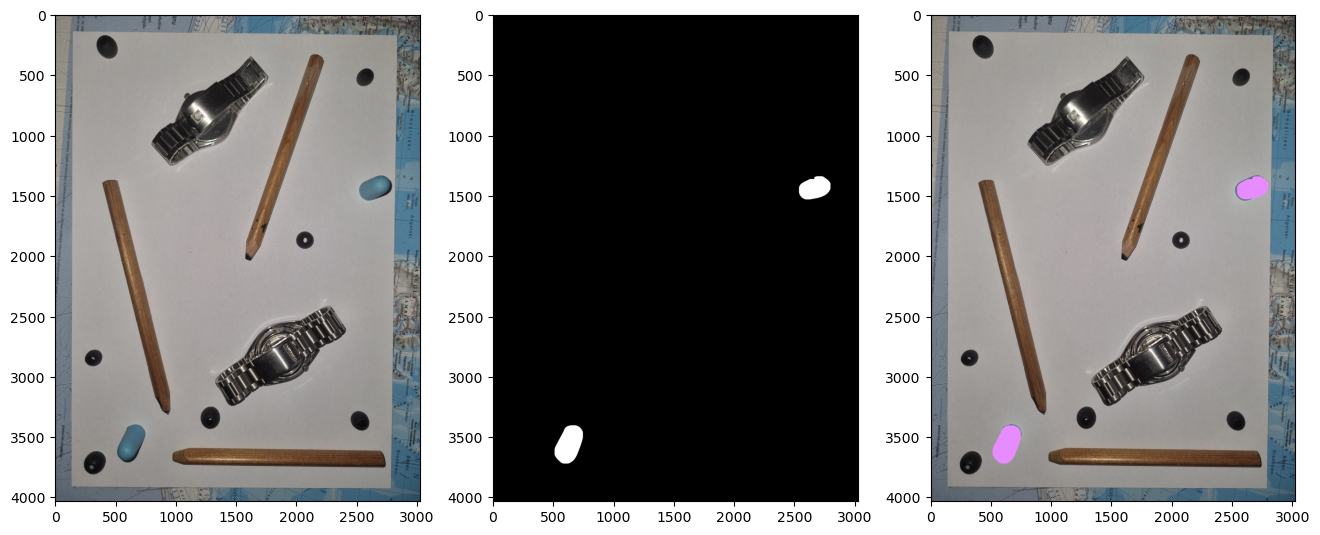

In [20]:
mark_objects(img, masks[3], (230,140,255))